## Categorizing Clothing with CNN
In this project we explore the use of convolutional neural nets for image classification; our dataset is a collection of 10 different types of clothing / accessories that we'll build a model to categorize. The goal of this notebook is to explore the initial dataset, fit a sequential CNN using keras, understand model parameters by testing their effect on model results, and finally, to evaluate the model's predictions and understand where it falls short. This notebook is 6-part:

1. Data Exploration
2. Convolutional Neural Nets: Exploration
3. Convolutional Neural Nets: Optimization
4. Visualizing Filters
5. Prediction Analysis
6. Conclusion

The comments in this notebook serve to orient the reader around my thought process at each step of the project. For a more in-depth explanation of convolutional neural nets and their applications, see my blog post here.

### 1. Data Exploration & Preprocessing
Here we import the dataset, do some light exploration to understand its attributes, and process the data for feeding into the model. Note that there is a uniform distribution across the 10 categories, and that all three shoe categories seem to contain images that are left-facing (toe pointing left). We will address the latter point in the modeling phase, when we use data augmentation to create more varied versions of these inputs.

Keras - the neural network library we will be using to construct our model - requires input vectors to have an extra dimension which correspond to their channels. Working with gray-scaled data, we only have one channel, so we reshape our train and test images to 28 x 28 x 1 3D matrices. Lastly, we create a validation dataset to evaluate our model's accuracy and watch for over/under-fitting during training.

In [45]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from collections import Counter
import time
import random

from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.datasets import mnist, fashion_mnist
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam

np.random.seed(2)
plt.style.use('fivethirtyeight')

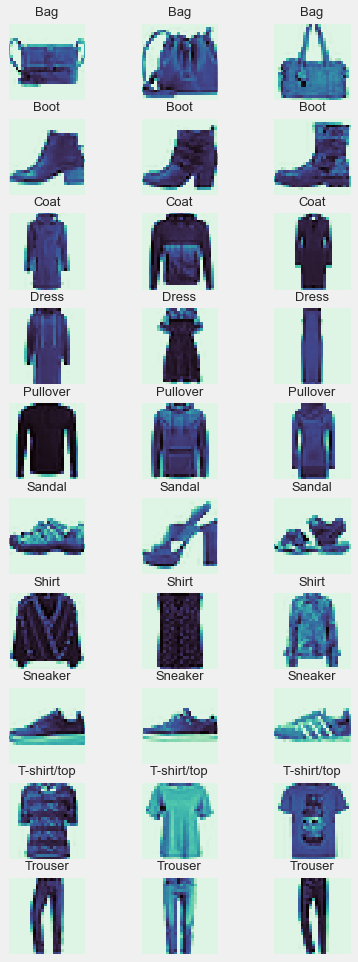

In [53]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

categories = {0: 'T-shirt/top',
             1: 'Trouser',
             2: 'Pullover',
             3: 'Dress',
             4: 'Coat',
             5: 'Sandal',
             6: 'Shirt',
             7: 'Sneaker',
             8: 'Bag',
             9: 'Boot'}

#plot random sample of each category
test = list(zip(x_train, [categories[x] for x in y_train]))
test_df = pd.DataFrame(test)

function = lambda obj: obj.loc[np.random.choice(obj.index, 3, False)]
grouped = test_df.groupby(1).apply(function)

fig, axes = plt.subplots(10, 3, figsize=(6,16))
axes = axes.flatten()
for i, image in enumerate(grouped[0]):
    axes[i].imshow(image, cmap='mako_r')
    axes[i].set_title(grouped[1][i], size=13)
    axes[i].set_xticks([])
    axes[i].set_yticks([])

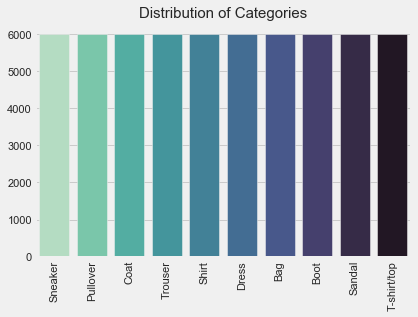

In [48]:
#plot distribution of categories
category_series = pd.Series(y_train).map(categories)
category_counts = category_series.value_counts()
sns.barplot(category_counts.index, category_counts, palette='mako_r')
ticks=plt.xticks(rotation='vertical')
title=plt.title('Distribution of Categories',size=15)

In [4]:
#check for nulls
print(f'Nulls in x_train: {np.isnan(x_train).sum()}')
print(f'Nulls in x_test: {np.isnan(x_test).sum()}')
print(f'Nulls in y_train: {np.isnan(y_train).sum()}')
print(f'Nulls in y_test: {np.isnan(y_test).sum()}')

Nulls in x_train: 0
Nulls in x_test: 0
Nulls in y_train: 0
Nulls in y_test: 0


In [5]:
#scaling to ease computational burden of model; CNN converges faster on [0,1] data than on [0,255]
#note: scaling does not change the way the image renders
x_train_scaled = x_train/255
x_test_scaled = x_test/255

#convert to float32, float64 uses twice as much memory
x_train_scaled_32 = x_train_scaled.astype('float32')
x_test_scaled_32 = x_test_scaled.astype('float32')

#reshape to 4d array with expected input shape of (batch, rows, columns, channels) for keras
#since images are grayscale (1 channel), last dimension is 1
x_train_scaled_shape = x_train_scaled_32.reshape(x_train_scaled_32.shape[0], 28, 28, 1)
x_test_scaled_shape = x_test_scaled_32.reshape(x_test_scaled_32.shape[0], 28, 28, 1)

#convert labels to one-hot-encoded arrays
y_train_cat = to_categorical(y_train, 10)
y_test_cat = to_categorical(y_test, 10)

#create validation set
#because we have uniform distribution of y labels, no need to stratify
#random_seed = 2
x_train_split, x_val_split, y_train_split, y_val_split = train_test_split(x_train_scaled_shape, y_train_cat, test_size=0.2, random_state=2)


### 2. Convolutional Neural Nets: Exploration
This section explores the effect of tuning CNN parameters, focusing on two hyperparameters in particular - 1) the number of filters in a convolutional layer (I will refer to this as the "filter value") and 2) kernel size. The create_params function creates a dictionary for every combination of these two parameters as indicated by the user; we then loop over this list of dictionaries to create a CNN for each set of parameters and store each model's results in a dataframe for further analysis. Note that for the sake of testing, we fit a simple model here, featuring just one convolutional layer and one dense layer. We will implement a more complex model focused on predictive accuracy in the next section.

After training the models, we look at how their accuracy scores, losses, and model training times compare across the number of filters and kernel sizes. The shaded regions represent error bars, as each filter value was fit with different kernel sizes, and each kernel size was likewise fit with different filter values.

From our pseudo-grid search, we glean the following:
- As expected, the accuracy and loss are improved with a higher number of filters - though as the number of epochs increases, the models with 60 filters perform only marginally better than those with 30.
- Model training time does increase with the number of filters, but not in a linear fashion - models with 5, 10, and 30 filters in the convolutional layer take a similar time to train (avg: 140 seconds), while the model with 60 filters takes longer (avg: 170 seconds) with greater variance. While this difference is not a significant inconvenience, it is useful to note that the 25% increase in model training time only yields a 0.7% increase in model accuracy. 
- We see a similar pattern with kernel size, although now smaller kernel sizes yield greater accuracy / lower loss as they enable the model to detect patterns over smaller receptive fields. 
- Interestingly, model training time does not change as we might expect with kernel size - my initial hypothesis was that the time would increase as the kernel size decreased, since our model will then need to compute a larger number of tensor products when convolving the filter through the input images. Instead, we see that model training time increases up until a certain point - perhaps because the time it takes to calculate the more complex tensor products outweighs the fact that more tensor products are being calculated - but only up to a certain point. At kernel size 28x28, our filters are the same size as our input image, meaning only one tensorproduct is calculated for each input, and model time therefore decreases.
- Across all models, accuracy and loss begins to flatten at 2 epochs, signifying that the marginal improvement of each epoch decreases beyond this point. This is most likely due to the dataset being rather simple - there is not much complexity to be learned beyond two pass-throughs of the model.


In [6]:
def create_params(values_dict: dict) -> list:
    """Create list of dictionaries for every combination of kernel / filter values indicated"""
    (key1, val1), (key2, val2) = values_dict.items()
    return [{key1: x, key2: y} for x in val1 for y in val2]

class CNN:
    """Creates a CNN object, which has methods create_model (to create CNN model) 
    and fit_model (to evaluate and record model results)"""
    def __init__(self, params_dict):
        self.params = params_dict
        self.kernels = params_dict['kernels']
        self.filters = params_dict['filters']
        self.model = self.create_model()
        
    
    def create_model(self):
        '''Simple Sequential model using variations of kernel size and number of filters as indicated by the user'''
        kernels = self.kernels
        filters = self.filters
        model = Sequential([Conv2D(filters=filters, kernel_size=kernels, activation='relu',input_shape=x_train_scaled_shape.shape[1:]),
                            Flatten(),
                            Dense(10, activation='softmax')])
        return model
    

    def fit_model(self, model, epochs=3, batch_size=100):
        start_time = time.time()
        kernels = self.kernels
        filters = self.filters
        model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
        datagen = ImageDataGenerator(rotation_range=10,
                                zoom_range=0.1,
                                width_shift_range=0.1,
                                height_shift_range=0.1)
    
        model_output = model.fit_generator(datagen.flow(x_train_scaled_shape, y_train_cat, batch_size=batch_size), epochs=epochs,
                                 validation_data=(x_test_scaled_shape, y_test_cat), steps_per_epoch=x_train_scaled_shape.shape[0]/batch_size)
        end_time = time.time()
        model_time = end_time - start_time
        history = pd.DataFrame(model_output.history)
        history['epoch'] = list(range(1, epochs+1))
        history['model_time'] = model_time
        history['filters'] = filters
        history['kernel_size'] = str(kernels)
        return history

In [7]:
testdict = {'kernels':[(5,5),(10,10),(15,15),(28,28)], 'filters':[5,10,30,60]}
params_list = create_params(testdict)

all_results = pd.DataFrame()
for param in params_list:
    cnn = CNN(param)
    model = cnn.create_model()
    model_results = cnn.fit_model(model, epochs=10, batch_size=100)
    all_results = all_results.append(model_results)

Epoch 1/10
600/600 [==============================] - 14s 24ms/step - loss: 0.7939 - accuracy: 0.7121 - val_loss: 0.5688 - val_accuracy: 0.7966
Epoch 2/10
600/600 [==============================] - 14s 23ms/step - loss: 0.6360 - accuracy: 0.7675 - val_loss: 0.5526 - val_accuracy: 0.7891
Epoch 3/10
600/600 [==============================] - 14s 23ms/step - loss: 0.5971 - accuracy: 0.7818 - val_loss: 0.5258 - val_accuracy: 0.8085
Epoch 4/10
600/600 [==============================] - 14s 23ms/step - loss: 0.5778 - accuracy: 0.7897 - val_loss: 0.4883 - val_accuracy: 0.8240
Epoch 5/10
600/600 [==============================] - 14s 23ms/step - loss: 0.5597 - accuracy: 0.7972 - val_loss: 0.4881 - val_accuracy: 0.8250
Epoch 6/10
600/600 [==============================] - 14s 23ms/step - loss: 0.5494 - accuracy: 0.8001 - val_loss: 0.4673 - val_accuracy: 0.8312
Epoch 7/10
600/600 [==============================] - 14s 23ms/step - loss: 0.5433 - accuracy: 0.8024 - val_loss: 0.4828 - val_accuracy:

Epoch 8/10
600/600 [==============================] - 16s 26ms/step - loss: 0.5126 - accuracy: 0.8105 - val_loss: 0.4523 - val_accuracy: 0.8354
Epoch 9/10
600/600 [==============================] - 16s 26ms/step - loss: 0.5050 - accuracy: 0.8122 - val_loss: 0.4381 - val_accuracy: 0.8404
Epoch 10/10
600/600 [==============================] - 15s 25ms/step - loss: 0.4980 - accuracy: 0.8156 - val_loss: 0.4362 - val_accuracy: 0.8418
Epoch 1/10
600/600 [==============================] - 17s 28ms/step - loss: 0.7320 - accuracy: 0.7302 - val_loss: 0.5455 - val_accuracy: 0.7962
Epoch 2/10
600/600 [==============================] - 17s 29ms/step - loss: 0.5727 - accuracy: 0.7878 - val_loss: 0.4835 - val_accuracy: 0.8246
Epoch 3/10
600/600 [==============================] - 17s 28ms/step - loss: 0.5276 - accuracy: 0.8049 - val_loss: 0.4597 - val_accuracy: 0.8355
Epoch 4/10
600/600 [==============================] - 17s 28ms/step - loss: 0.5088 - accuracy: 0.8123 - val_loss: 0.4501 - val_accuracy

,val_loss,val_accuracy,loss,accuracy,epoch,model_time,filters,kernel_size
0,0.568831,0.7966,0.793894,0.712083,1,137.938045,5,"(5, 5)"
1,0.552587,0.7891,0.636041,0.767517,2,137.938045,5,"(5, 5)"
2,0.525786,0.8085,0.597137,0.781767,3,137.938045,5,"(5, 5)"
3,0.488251,0.8240,0.577785,0.789700,4,137.938045,5,"(5, 5)"
4,0.488115,0.8250,0.559656,0.797167,5,137.938045,5,"(5, 5)"


In [69]:
all_results.head()

,val_loss,val_accuracy,loss,accuracy,epoch,model_time,filters,kernel_size
0,0.568831,0.7966,0.793894,0.712083,1,137.938045,5,"(5, 5)"
1,0.552587,0.7891,0.636041,0.767517,2,137.938045,5,"(5, 5)"
2,0.525786,0.8085,0.597137,0.781767,3,137.938045,5,"(5, 5)"
3,0.488251,0.8240,0.577785,0.789700,4,137.938045,5,"(5, 5)"
4,0.488115,0.8250,0.559656,0.797167,5,137.938045,5,"(5, 5)"


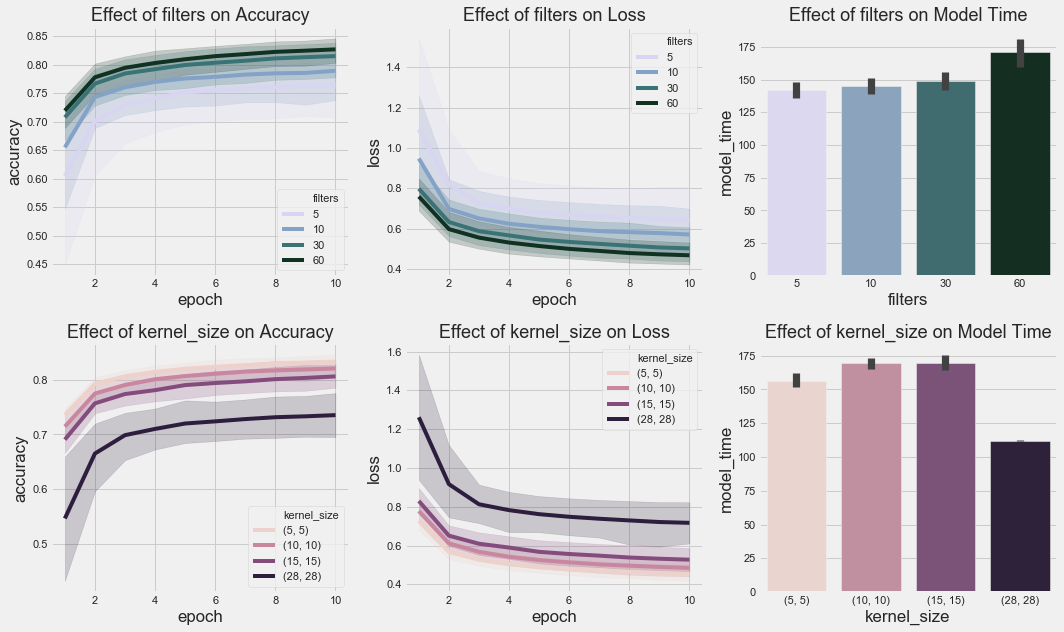

In [99]:
#visualize effects of different parameters on model results and training time
fig, axes = plt.subplots(2,3,figsize=(15,9))
axes = axes.flatten()
for i, metric in enumerate(['filters','kernel_size']):
    sns.lineplot('epoch','accuracy',data=all_results, hue=metric, ax=axes[i*3], palette=sns.cubehelix_palette(4, start=i+11))
    axes[i*3].set_title('Effect of '+metric+' on Accuracy',size=18)
    axes[i*3].legend(loc='lower right')
    sns.lineplot('epoch','loss',data=all_results, hue=metric, ax=axes[i*3+1], palette=sns.cubehelix_palette(4, start=i+11))
    axes[i*3+1].set_title('Effect of '+metric+' on Loss',size=18)
    sns.barplot(metric,'model_time',data=all_results,ax=axes[i*3+2], palette=sns.cubehelix_palette(4, start=i+11))
    axes[i*3+2].set_title('Effect of '+metric+' on Model Time',size=18)
    plt.tight_layout()

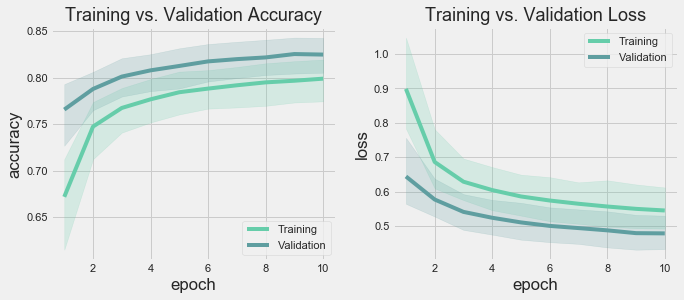

In [97]:
#plot accuracy and loss across all models
fig, axes = plt.subplots(1,2,figsize=(10,4))
sns.lineplot('epoch','accuracy',data=all_results, ax=axes[0], label='Training', color='mediumaquamarine')
sns.lineplot('epoch','val_accuracy',data=all_results, ax=axes[0], label='Validation', color='cadetblue')
axes[0].set_title('Training vs. Validation Accuracy', size=18)
axes[0].set_ylabel('accuracy')
axes[0].legend(loc='lower right')

sns.lineplot('epoch','loss',data=all_results, ax=axes[1], label='Training', color='mediumaquamarine')
sns.lineplot('epoch','val_loss',data=all_results, ax=axes[1], label='Validation', color='cadetblue')
axes[1].set_title('Training vs. Validation Loss', size=18)
axes[1].set_ylabel('loss')
title=axes[1].legend(loc='upper right')

### 3. Convolutional Neural Nets: Optimization
With the more complex model below, our goal is no longer exploration, but accuracy. The model architecture is as follows: (Convolutional Layer + Convolutional Layer + Maxpool Layer + Dropout)*2 + (Flatten + Dense + Dropout + Dense). We test the effect of data augmentation by using Keras' image generator to vary our inputs and bolster our model's ability to generalize to unseen data.

This last model achieves a validation accuracy of 92% over 10 epochs - compared to the best model in the previous section (one convolutional layer, 60 filters, kernel size of (5,5)) which achieved 84% accuracy on the validation set, we see the additional layers yield an 8% accuracy improvement. Keep in mind that because this is a rather simple input dataset (only 10 possible outputs, grayscale, uniform distribution of categories, objects are similar sizes) the out-of-the-box accuracy with just one convolutional layer is already pretty high, as observed in the section above. With a more complicated input dataset, we would expect to see a more striking lift in accuracy by adding more convolutional layers.

In [10]:
model_advanced = Sequential([Conv2D(filters=32, kernel_size=(5,5), padding='Same', activation='relu',input_shape=x_train_scaled_shape.shape[1:]),
                   Conv2D(filters=32, kernel_size=(5,5), padding='Same', activation='relu'),
                   MaxPool2D(pool_size=(2,2)),
                   Dropout(0.25),

                   Conv2D(filters=32, kernel_size=(5,5), padding='Same', activation='relu'),
                   Conv2D(filters=32, kernel_size=(5,5), padding='Same', activation='relu'),
                   MaxPool2D(pool_size=(2,2)),
                   Dropout(0.25),

                   Flatten(),
                   Dense(256, activation='relu'),
                   Dropout(0.5),
                   Dense(10, activation='softmax')])

model_advanced.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

model_advanced.summary()
epochs=10
batch_size=100

history_no_aug = model_advanced.fit(x_train_split, y_train_split, batch_size=batch_size, epochs=epochs,
                                  validation_data=(x_val_split, y_val_split), verbose=1)

Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_33 (Conv2D)           (None, 28, 28, 32)        832       
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 28, 28, 32)        25632     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 14, 14, 32)        25632     
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 14, 14, 32)        25632     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 32)        

In [11]:
datagen = ImageDataGenerator(featurewise_center=False,
                            samplewise_center=False,
                            featurewise_std_normalization=False,
                            samplewise_std_normalization=False,
                            zca_whitening=False,
                            rotation_range=10,
                            zoom_range=0.1,
                            width_shift_range=0.1,
                            height_shift_range=0.1,
                            horizontal_flip=True,
                            vertical_flip=False)
datagen.fit(x_train_split)

history_advanced = model_advanced.fit_generator(datagen.flow(x_train_split, y_train_split, batch_size=batch_size),
                                                   epochs=epochs, validation_data=(x_val_split, y_val_split),
                                                   verbose=1, steps_per_epoch=x_train_split.shape[0]//batch_size)

Epoch 1/10
480/480 [==============================] - 99s 207ms/step - loss: 0.4835 - accuracy: 0.8239 - val_loss: 0.2350 - val_accuracy: 0.9128
Epoch 2/10
480/480 [==============================] - 100s 208ms/step - loss: 0.3955 - accuracy: 0.8540 - val_loss: 0.2399 - val_accuracy: 0.9122
Epoch 3/10
480/480 [==============================] - 98s 205ms/step - loss: 0.3669 - accuracy: 0.8644 - val_loss: 0.2304 - val_accuracy: 0.9154
Epoch 4/10
480/480 [==============================] - 97s 202ms/step - loss: 0.3508 - accuracy: 0.8709 - val_loss: 0.2305 - val_accuracy: 0.9147
Epoch 5/10
480/480 [==============================] - 96s 201ms/step - loss: 0.3420 - accuracy: 0.8735 - val_loss: 0.2289 - val_accuracy: 0.9161
Epoch 6/10
480/480 [==============================] - 97s 202ms/step - loss: 0.3316 - accuracy: 0.8781 - val_loss: 0.2536 - val_accuracy: 0.9053
Epoch 7/10
480/480 [==============================] - 97s 202ms/step - loss: 0.3269 - accuracy: 0.8803 - val_loss: 0.2224 - val_a

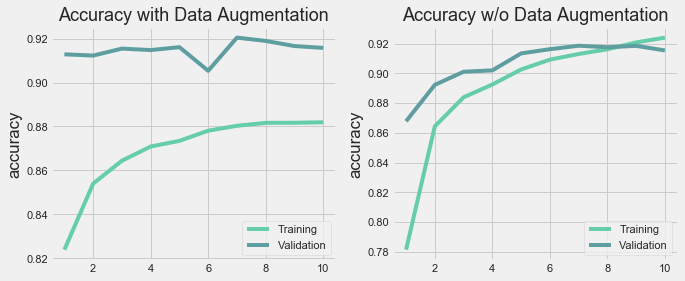

In [113]:
data_aug = pd.DataFrame(history_advanced.history)
no_data_aug = pd.DataFrame(history_no_aug.history)

#plot accuracy and loss across all models
fig, axes = plt.subplots(1,2,figsize=(10,4))
sns.lineplot(range(1,11),'accuracy',data=data_aug, ax=axes[0], label='Training', color='mediumaquamarine')
sns.lineplot(range(1,11),'val_accuracy',data=data_aug, ax=axes[0], label='Validation', color='cadetblue')
axes[0].set_title('Accuracy with Data Augmentation', size=18)
axes[0].set_ylabel('accuracy')
axes[0].legend(loc='lower right')

sns.lineplot(range(1,11),'accuracy',data=no_data_aug, ax=axes[1], label='Training', color='mediumaquamarine')
sns.lineplot(range(1,11),'val_accuracy',data=no_data_aug, ax=axes[1], label='Validation', color='cadetblue')
axes[1].set_title('Accuracy w/o Data Augmentation', size=18)
axes[1].set_ylabel('accuracy')
title=axes[1].legend(loc='lower right')

### 4. Visualizing Filters
I thought it would be an interesting exercise to visualize the outputs from each of the convolutional layers, or feature maps, to further unpack how a CNN works. Here we display the results of three of the convolutional layers in the model from section 3 to look at what the model sees during training. While individual feature maps don't show any discernible patterns or shapes, we gain a sense for how the model "thinks" at each layer of the network. Note that lighter colors represent where each filter was more heavily activated.

In [131]:
layer_dict = dict([(layer.name, layer) for layer in model_advanced.layers])
layer_name = 'conv2d_149'

def visualize_filters(layer_name):
    filter_index = 0

    filters, biases = layer_dict[layer_name].get_weights()

    f_min, f_max = np.amin(filters), np.amax(filters)
    filters = (filters-f_min)/(f_max-f_min)

    n_filters, index = 6,1
    for i in range(n_filters):
        f = filters[:,:,:,i]

        for j in range(3):
            ax=plt.subplot(n_filters, 3, index)
            ax.set_xticks([])
            ax.set_yticks([])
            plt.imshow(f[:,:,j], cmap='mako')
            index +=1
    plt.show()

Feature maps from conv2d_34


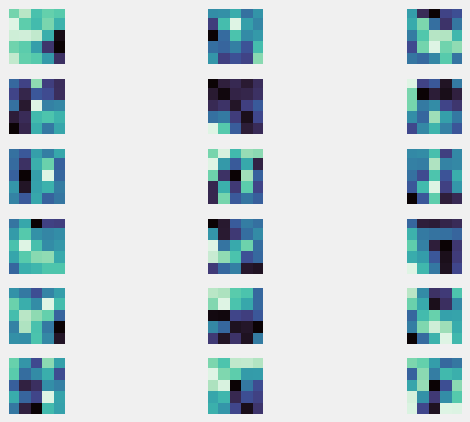

Feature maps from conv2d_35


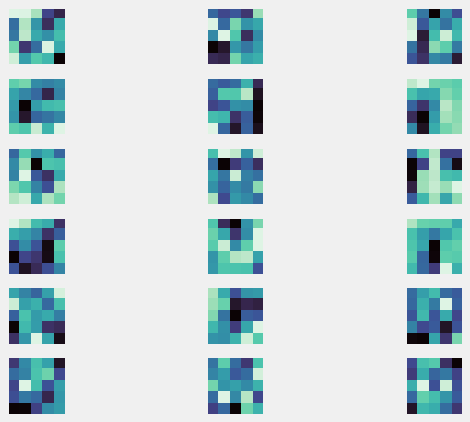

Feature maps from conv2d_36


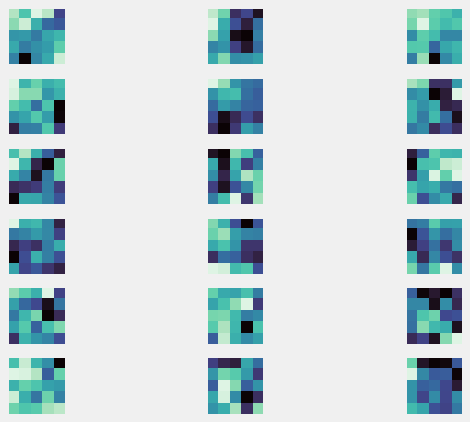

In [134]:
convolutional_layers = [x for x in layer_dict if 'conv' in x]
#second convolutional layer

for layer in convolutional_layers[1:]:
    print(f'Feature maps from {layer}')
    visualize_filters(layer)

### 5. Prediction analysis
Aaaand lastly - time to make our predictions. Using the model from section 3 as our final model (with data augmentation), we predict the category for each of our 10,000 test samples. Seeing as there is also a uniform distribution of categories in our test labels (1,000 each), we can compare the predicted results to each other without converting to percentages.

We see that sandals, bags, and trousers are the most often correctly predicted, whereas T-shirts, pullovers, and shirts are the most often incorrectly predicted. Makes sense, as the first three categories have relatively distinguishable shapes compared to the last three. In terms of the most common incorrect combinations, shirts are the top mislabled, most often being confused with t-shirts and coats - not too ridiculous of a mistake to make. 

In [139]:
pd.Series([categories[y] for y in y_test]).value_counts()

T-shirt/top    1000
Sneaker        1000
Coat           1000
Pullover       1000
Shirt          1000
Dress          1000
Bag            1000
Trouser        1000
Boot           1000
Sandal         1000
dtype: int64

In [116]:
#calculate predictions
predictions = model_advanced.predict(x_test_scaled_shape)
predicted = [np.argmax(x) for x in predictions]
mapped_prediction = [categories[prediction] for prediction in predicted]
mapped_y_test = [categories[y] for y in y_test]
pred_df = pd.DataFrame(zip(predicted, y_test, mapped_prediction, mapped_y_test)).rename(columns={0:'predicted',1:'actual', 2:'predicted_label',3:'actual_label'})

pred_df['correct'] = pred_df['actual'] == pred_df['predicted']
correct = pred_df.groupby('actual_label')[['correct']].sum().sort_values('correct', ascending=False).astype(int)
display(correct)

wrong = pred_df[pred_df['correct']==False].groupby(['actual_label','predicted_label'])[['correct']].count().sort_values('correct',ascending=False).rename(columns={'correct':'Count'})
top5_wrong = wrong.nlargest(10, 'Count')
display(top5_wrong)


,correct
actual_label,
Sandal,994
Bag,991
Trouser,983
Boot,956
Sneaker,956
Dress,916
Coat,905
T-shirt/top,901
Pullover,818


Count
actual_label predicted_label       
Shirt        T-shirt/top        161
             Coat                89
Pullover     Coat                83
             Shirt               65
T-shirt/top  Shirt               59
Coat         Shirt               57
Boot         Sneaker             37
Shirt        Pullover            36
             Dress               30
Dress        Coat                29

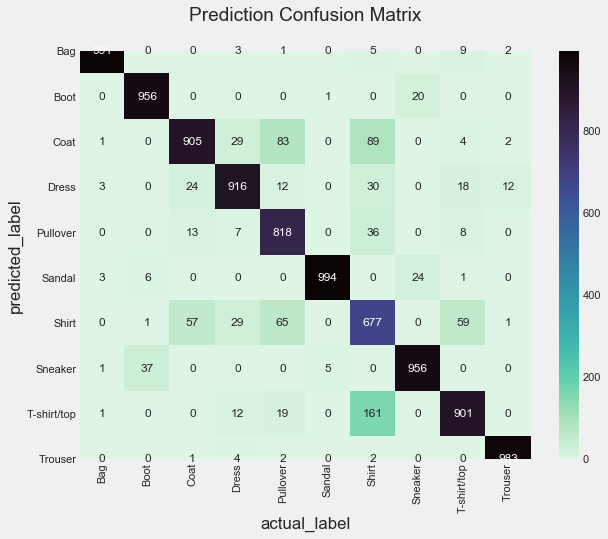

In [201]:
#plot confusion matrix for test samples
#unfortunately top / bottom rows get cut off due to a matplotlib bug
pivot = pred_df.pivot_table('correct',index='predicted_label',columns='actual_label',aggfunc='count').fillna(0)
plt.rcParams['figure.figsize']=(9,7)
sns.heatmap(pivot, cmap='mako_r', annot=True, fmt='.0f', annot_kws={"size": 12})
title=plt.title('Prediction Confusion Matrix', size=19, pad = 30)

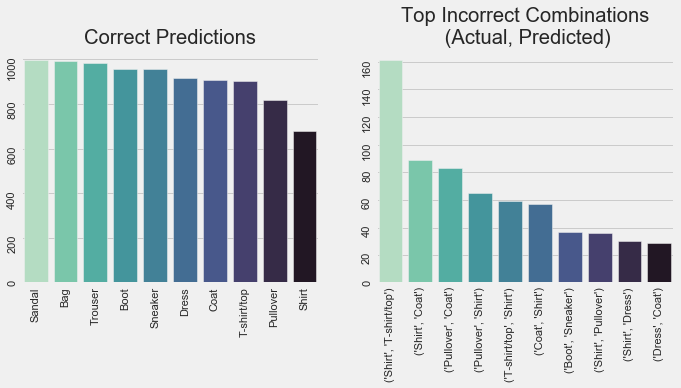

In [207]:
fig, axes = plt.subplots(1,2, figsize=(10, 5))
sns.barplot(correct.index, correct['correct'], ax=axes[0], palette='mako_r')
axes[0].set_title('Correct Predictions')
axes[0].tick_params(labelrotation=90)
axes[0].set_ylabel('')
axes[0].set_xlabel('')

sns.barplot(top5_wrong.index, top5_wrong['Count'], ax=axes[1], palette='mako_r')
axes[1].set_title('Top Incorrect Combinations\n (Actual, Predicted)')

plt.tight_layout()
axes[1].tick_params(labelrotation=90)
y=axes[1].set_ylabel('')

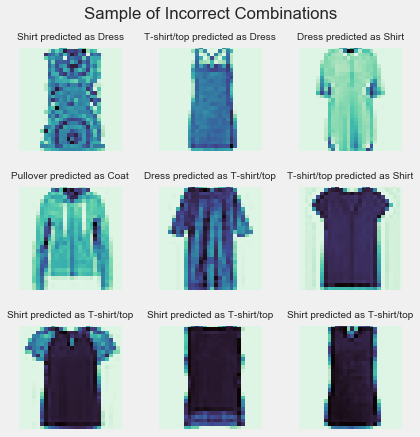

In [233]:
incorrect = pred_df[pred_df['actual_label']!=pred_df['predicted_label']]
incorrect_indices = incorrect.index

sampling_incorrect = random.choices(incorrect_indices, k=9)
fig, axes = plt.subplots(3,3,figsize=(6,6))
axes = axes.flatten()

for i,index in enumerate(sampling_incorrect):
    actual_label = pred_df.iloc[index]['actual_label']
    predicted_label = pred_df.iloc[index]['predicted_label']
    axes[i].imshow(x_test_scaled[index], cmap='mako_r')
    axes[i].set_title(actual_label +' predicted as '+predicted_label, size=10)
    axes[i].grid(False)
    axes[i].set_xticks([])
    axes[i].set_yticks([])
plt.suptitle('Sample of Incorrect Combinations', y=1.02)
plt.tight_layout()

### 6. Conclusion